In [3]:
# rates from Teitinen's paper:
#Teittinen, Jose et al. “Revealing memory effects in phase-covariant 
# quantum master equations.” New Journal of Physics (2018): n. pag.
#k tau is changing, d and meu are constant
import matplotlib.pyplot as plt
import numpy as np
import cmath
from scipy.integrate import quad
import math

def Nth(kt): #omega not is 0, h bar is 1
    if kt==0:
        n=0
    else:
        n=(np.exp(1/kt)-1)**(-1)
    return n

def funct(l,k,t):
    d=cmath.sqrt(l**2-2*k*l)
    ft=(2*k*(l/d)*cmath.sinh(0.5*d*t))/(cmath.cosh(0.5*d*t)+(l/d)*cmath.sinh(0.5*d*t))
    return ft.real

def g1(kt,l,k,t): #gamma1
    g1=2*Nth(kt)*funct(l,k,t)
    return g1

def g2(kt,l,k,t): #gamma2
    g2=2*(Nth(kt)+1)*funct(l,k,t)
    #g2=2*funct(kt,l,k,t)
    return g2

def g3(kt,c,s,t): #gamma3
    if kt==0:
        func=lambda x1:((x1/c)**s)*(np.exp(-x1/c))*math.sin(x1*t)
    else:
        func=lambda x1:((x1/c)**s)*(np.exp(-x1/c))*math.sin(x1*t)*(1/math.tanh(x1/kt))
    ga=quad(func,0,math.inf)
    return 2*ga[0]

def tevolve(kt,l,k,c,s,t,rho): #evolution of the density matrix
    d=cmath.sqrt(l**2-2*k*l)
    xt=np.exp(-l*t)*(cmath.cosh(0.5*d*t)+(l/d)*cmath.sinh(0.5*d*t))**2
    p1t=xt**(2*Nth(kt)+1)*rho[1,1]+((Nth(kt)+1)/(2*Nth(kt)+1))*(1-xt**(2*Nth(kt)+1))
    if kt==0:
        func=lambda x:((x**(s-1))/c**s)*np.exp(-x/c)*(1-math.cos(x*t))
    else:
        func=lambda x:((x**(s-1))/c**s)*np.exp(-x/c)*(1-math.cos(x*t))*(1/math.tanh(x/kt))
    gm=2*quad(func,0,math.inf)[0]
    coh=rho[0,1]*cmath.sqrt(xt)*np.exp(-gm)
    rhot=np.zeros((2,2))
    rhot[0,0]=1-p1t.real
    rhot[1,1]=p1t.real
    rhot[0,1]=coh.real
    rhot[1,0]=coh.real
    return rhot

def lind(kt,l,k,c,s,t,rhot): #time local convolutionless master equation
    sz=np.array([[1,0],[0,-1]])
    sp=np.array([[0,1],[0,0]])
    sm=np.array([[0,0],[1,0]])
    ld=np.zeros((2,2))
    ld=0.5*g1(kt,l,k,t)*(sp@rhot@sm-0.5*(sm@sp@rhot+rhot@sm@sp))+0.5*g2(kt,l,k,t)*(sm@rhot@sp-0.5*(sp@sm@rhot+rhot@sp@sm))+0.5*g3(kt,c,s,t)*(sz@rhot@sz-rhot)
    #ld=0.5*g2(kt,l,k,t)*(sm@rhot@sp-0.5*(sp@sm@rhot+rhot@sp@sm))
    return ld

def maxvalgen(kt,l,k,c,s,t,rho): #generates the required max value
    rhot=tevolve(kt,l,k,c,s,t,rho)
    norm=lind(kt,l,k,c,s,t,rhot).T@lind(kt,l,k,c,s,t,rhot)
    val=np.linalg.eig(norm)[0]
    fx=np.sqrt(max(abs(val))) #converts into float from complex
    return fx

def bures(kt,l,k,c,s,time,rho): #bures angle
    z1=0
    garb=np.zeros((2,2))
    garb=tevolve(kt,l,k,c,s,time,rho)@rho
    f=np.sqrt(garb.trace())+2*np.sqrt(np.linalg.det(rho)*np.linalg.det(tevolve(kt,l,k,c,s,time,rho)))
    z1=math.acos(np.sqrt(f))
    b=np.sin(z1)**2
    return b

kt=[0,0.5] #different temperatures
k=np.arange(0.51,50,0.5) ##this essentially becomes R when l=1, and R>1/2 non markov
l=1
s=4
c=1
cases=len(kt) #values of c

rho=np.array([[0.5,0.5],[0.5,0.5]])  #maximal coherent initial state
#rho=np.array([[1,0],[0,0]]) 
time=1 #will give upper limits
n=200;#no. of points in the smaller integrations

a=0 #lower limit
b=time #upper limit
fint=np.zeros((cases,len(k)))
bur=np.zeros((cases,len(k)))
qsl=np.zeros((cases,len(k)))
revqsl=np.zeros((cases,len(k)))

for j in range(cases):
    for i in range(len(k)):
        f=lambda x:maxvalgen(kt[j],l,k[i],c,s,x,rho)
        fint[j,i]=quad(f,a,b)[0]
        bur[j,i]=bures(kt[j],l,k[i],c,s,time,rho)
    qsl[j,:]=np.divide(bur[j,:],fint[j,:])
    revqsl[j,:]=np.divide(fint[j,:],bur[j,:])

rhot=np.zeros((2,2))
garb=np.zeros((2,2))
Cpar=np.zeros((cases,len(k)))
mix=np.zeros((cases,len(k)))
bound=np.zeros((cases,len(k)))
for j in range(cases): # for finding the mixedness-coherence balance
    for i in range(len(k)):
        rhot=tevolve(kt[j],l,k[i],c,s,time,rho)
        Cpar[j,i]=abs(rhot[0,1])+abs(rhot[1,0])
        garb=rhot@rhot
        mix[j,i]=2*(1-garb.trace())
        bound[j,i]=4*rhot[0,0]*rhot[1,1]
        i=i+1
    i=0


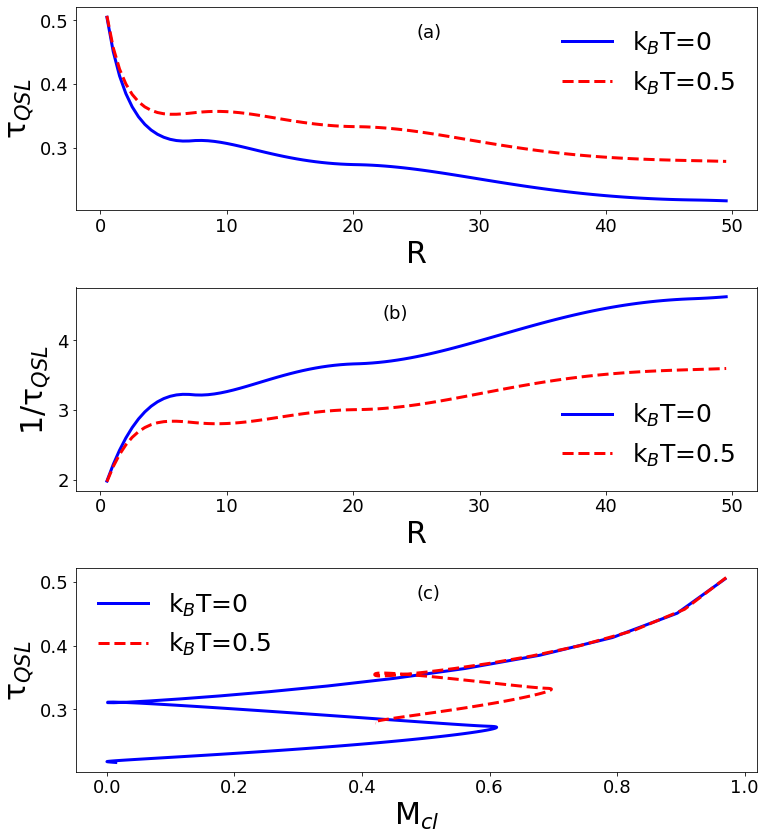

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(tight_layout=True,figsize=(11,12))
plt.rcParams.update({'font.size': 18})
gs = gridspec.GridSpec(3, 3)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(k,qsl[0,:],'b',linewidth=3, label='k$_{B}$T=0')
ax1.plot(k,qsl[1,:],'r--', linewidth=3, label='k$_{B}$T=0.5')
ax1.set_xlabel('R',fontsize=30)
ax1.set_ylabel('\u03C4$_{QSL}$',fontsize=30)
ax1.text(0.5, 0.85, '(a)',transform=ax1.transAxes)
ax1.legend(frameon=False, fontsize=25)

ax2 = fig.add_subplot(gs[1, :])
ax2.plot(k,revqsl[0,:],'b',linewidth=3, label='k$_{B}$T=0')
ax2.plot(k,revqsl[1,:],'r--',linewidth=3, label='k$_{B}$T=0.5')
ax2.legend(frameon=False, fontsize=25)
ax2.text(0.45, 0.85, '(b)',transform=ax2.transAxes)
ax2.set_xlabel('R',fontsize=30)
ax2.set_ylabel('1/\u03C4$_{QSL}$',fontsize=30)

ax3 = fig.add_subplot(gs[2, :])
ax3.plot(bound[0,:],qsl[0,:],'b',linewidth=3,label='k$_{B}$T=0')
ax3.plot(bound[1,:],qsl[1,:],'r--',linewidth=3,label='k$_{B}$T=0.5')
ax3.set_xlabel('M$_{cl}$',fontsize=30)
ax3.set_ylabel('\u03C4$_{QSL}$',fontsize=30)
ax3.text(0.5, 0.85, '(c)',transform=ax3.transAxes)
ax3.legend(frameon=False, fontsize=25)

#fig.savefig('ad_ttnn.png',dpi=120,bbox_inches='tight',pad_inches = 0.1)